# Create subject set for Galaxy Builder

Given a list of Ra, Dec pairs, this notebook performs matching to the NSA catalogue, looks up information in the MaNGA catalogue and creates a list of Galaxy Builder subjects in the output folder provided.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import json
import re
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import panoptes_client
from tqdm import tqdm
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import match_coordinates_sky
from panoptes_client import SubjectSet, Subject, Project, Panoptes
import sdssCutoutGrab as scg
import subjectCreator as subC

In [3]:
input_catalog = 'MaNGASpirals127_WestfallRotn_GZ2.fits'
subject_set_name = 'sa_subject_set'
nsa_catalogue_location = 'nsa_v1_0_1.fits'
manga_catalogue_location = 'MaNGA_gz.fits'
catalog_output = 'sa_subject_set.csv' # set to None if not wanted, must be csv file

In [4]:
if input_catalog.split('.')[-1] == 'fits':
    catalog_data = pd.DataFrame(
        fits.open(input_catalog)[1].data
    )
elif input_catalog.split('.')[-1] == 'csv':
    catalog_data = pd.read_csv(input_catalog)

catalog_data.columns = catalog_data.columns.map(lambda s: s.lower())

In [5]:
nsa_cat = fits.open(nsa_catalogue_location)[1].data
manga_gz = fits.open(manga_catalogue_location)[1].data

In [6]:
sa_coords = SkyCoord(
    ra=catalog_data['ra'].values * u.degree,
    dec=catalog_data['dec'].values * u.degree,
)

nsa_coords = SkyCoord(
    ra=nsa_cat['RA'] * u.degree,
    dec=nsa_cat['DEC'] * u.degree,
)

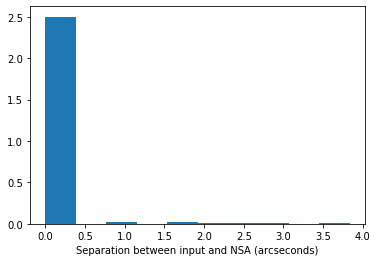

In [7]:
jsFull, sep2d, d3d = match_coordinates_sky(sa_coords, nsa_coords)
jsMask = sep2d < 5*u.arcsecond
js = jsFull[jsMask]

plt.hist(sep2d[jsMask].arcsecond, density=True)
plt.xlabel('Separation between input and NSA (arcseconds)');

In [8]:
keys = (
    'RA', 'DEC', 'Z', 'ZDIST',
    'ISDSS', 'INED', 'NSAID', 'IAUNAME',
    'RUN', 'CAMCOL', 'FIELD', 'RERUN',
    'PETRO_THETA', 'SERSIC_BA',
)
nsa_match = pd.DataFrame(
    {k: nsa_cat[jsFull][k].byteswap().newbyteorder() for k in keys}
).rename(columns={
    'RA': 'ra', 'DEC': 'dec', 'Z': 'z',
    'ISDSS': 'dr7objid', 'PETRO_THETA': 'petrotheta',
})
nsa_match.head()

,ra,dec,z,ZDIST,dr7objid,INED,NSAID,IAUNAME,RUN,CAMCOL,FIELD,RERUN,petrotheta,SERSIC_BA
0,189.213253,45.651170,0.030345,0.030521,-1,-1,668920,J123650.90+453902.9,3813,5,247,301,17.003117,0.817457
1,213.416820,43.866565,0.035045,0.035309,286679,151381,281486,J141340.03+435159.7,3699,4,155,301,24.384027,0.801103
2,213.783652,45.594849,0.015943,0.016606,253602,151727,249054,J141508.07+453541.4,2964,2,453,301,21.133516,0.470907
3,199.942789,47.715574,0.028828,0.029080,306655,135480,301449,J131946.26+474255.9,3716,6,105,301,19.284403,0.647211
4,128.687741,52.715686,0.044879,0.045203,50037,57678,49570,J083445.04+524256.4,1350,3,167,301,20.655245,0.386585


In [9]:
NEEDED_MANGA_KEYS = ('MANGAID',)
nsa_match['Plate IFU'] = pd.DataFrame(
    dict(MANGAID=manga_gz['MANGAID']),
    index=manga_gz['nsa_id']
).reindex(nsa_match.NSAID).reset_index(drop=True)
base_marvin_url = 'https://dr15.sdss.org/marvin/galaxy/{}/'
nsa_match['Marvin URL'] = nsa_match['Plate IFU'].apply(
    lambda i: base_marvin_url.format(i)
)
nsa_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 16 columns):
ra            196 non-null float64
dec           196 non-null float64
z             196 non-null float32
ZDIST         196 non-null float32
dr7objid      196 non-null int32
INED          196 non-null int32
NSAID         196 non-null int32
IAUNAME       196 non-null object
RUN           196 non-null int16
CAMCOL        196 non-null uint8
FIELD         196 non-null int16
RERUN         196 non-null object
petrotheta    196 non-null float32
SERSIC_BA     196 non-null float32
Plate IFU     195 non-null object
Marvin URL    196 non-null object
dtypes: float32(4), float64(2), int16(2), int32(3), object(4), uint8(1)
memory usage: 15.6+ KB


In [10]:
if catalog_output is not None:
    nsa_match.to_csv(catalog_output)

In [11]:
files, success, err, montageFailures = [], [], [], []
original = sys.stdout
with open('file_creation_log.log', 'w') as f:
    for i, gal in tqdm(nsa_match.dropna().iterrows()):
        try:
            sys.stdout = f
            extra_meta = {
                'Plate IFU': gal['Plate IFU'],
                'Marvin URL': "[View on Marvin](+tab+{})".format(
                    gal['Marvin URL'],
                ),
            }
            res = subC.pipeline(
                gal,
                outputFolder=subject_set_name,
                subjectName='subject{}'.format(i),
                extra_metadata=extra_meta,
                source_extraction_kwargs=dict(threshold=0.05, minarea=5, deblend_cont=0.05),
            )
            if res:
                success += [i]
                files += [res]
            else:
                montageFailures += [i]
            sys.stdout.flush()
        except Exception as e:
            sys.stdout = original
            print(i)
            raise(e)
        finally:
            sys.stdout = original
        sys.stdout = original

9it [03:31, 30.05s/it]WARNING: FITSFixedWarning: RADECSYS= 'ICRS ' / International Celestial Ref. System 
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
16it [06:46, 27.26s/it]WARNING: FITSFixedWarning: RADECSYS= 'ICRS ' / International Celestial Ref. System 
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
31it [12:53, 20.17s/it]WARNING: FITSFixedWarning: RADECSYS= 'ICRS ' / International Celestial Ref. System 
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
36it [14:18, 20.54s/it]WARNING: FITSFixedWarning: RADECSYS= 'ICRS ' / International Celestial Ref. System 
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
40it [15:13, 16.30s/it]WARNING: FITSFixedWarning: RADECSYS= 'ICRS ' / International Celestial Ref. System 
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
49it [17:35, 22.03s/it]WARNING: FITSFixedWarning: RADECSYS= 'ICRS ' / International Celestial Ref. System 
the RADECSYS keywor

KeyboardInterrupt: 

# Upload to the Zooniverse

We've made our subject set, now to send it on its merry way, use 

`python uploadSubjects.py [subject_set_folder] [subject_set_name]`

(as an admin)